<a href="https://colab.research.google.com/github/reiinakano/neural-painters/blob/master/notebooks/train_vae_painter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optionally connect to Google Drive

#imports

In [1]:
# pip uninstall -y tensorflow-gpu

In [1]:
# pip install tensorflow-gpu

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

import tensorflow as tf
import os

import sys
# sys.path.append('mypaint')
# sys.path.append('SPIRAL-tensorflow')

# from lib import surface, tiledsurface, brush
# from envs.mypaint_utils import *

from IPython.display import display

import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import matplotlib.pyplot as plt


# 

In [3]:
# class args:
#   jump=True
#   curve=True
#   screen_size=64
#   location_size=32
#   color_channel=3
#   brush_path='SPIRAL-tensorflow/assets/brushes/dry_brush.myb'
#   train=True
#   data_dir=Path('data')

# painting environment

In [4]:
# class PaintMode:
#   STROKES_ONLY = 0
#   JUMP_STROKES = 1
#   CONNECTED_STROKES = 2

# class ColorEnv():
#     head = 0.25
#     tail = 0.75

#     # all 0 to 1
#     actions_to_idx = {
#         'pressure': 0,
#         'size': 1,
#         'control_x': 2,
#         'control_y': 3,
#         'end_x': 4,
#         'end_y': 5,
#         'color_r': 6,
#         'color_g': 7,
#         'color_b': 8,
#         'start_x': 9,
#         'start_y': 10,
#         'entry_pressure': 11,
#     }

#     def __init__(self, args, paint_mode=PaintMode.JUMP_STROKES):
#         self.args = args
#         self.paint_mode = paint_mode

#         # screen
#         self.screen_size = args.screen_size
#         self.height, self.width = self.screen_size, self.screen_size
#         self.observation_shape = [
#                 self.height, self.width, args.color_channel]

#         # location
#         self.location_size = args.location_size
#         self.location_shape = [self.location_size, self.location_size]

#         self.prev_x, self.prev_y, self.prev_pressure = None, None, None

#     @staticmethod
#     def pretty_print_action(ac):
#         for k, v in ColorEnv.actions_to_idx.items():
#             print(k, ac[v])

#     def random_action(self):
#         return np.random.uniform(size=[len(self.actions_to_idx)])

#     def reset(self):
#         self.intermediate_images = []
#         self.prev_x, self.prev_y, self.prev_pressure = None, None, None

#         self.s = tiledsurface.Surface()
#         self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
#         self.s.begin_atomic()

#         with open(self.args.brush_path) as fp:
#             self.bi = brush.BrushInfo(fp.read())
#         self.b = brush.Brush(self.bi)

#     def draw(self, ac, s=None, dtime=1):
#         # Just added this
#         if self.paint_mode == PaintMode.STROKES_ONLY:
#           self.s.clear()
#           self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
#           self.s.end_atomic()
#           self.s.begin_atomic()

#         if s is None:
#             s = self.s

#         s_x, s_y = ac[self.actions_to_idx['start_x']]*64, ac[self.actions_to_idx['start_y']]*64
#         e_x, e_y = ac[self.actions_to_idx['end_x']]*64, ac[self.actions_to_idx['end_y']]*64
#         c_x, c_y = ac[self.actions_to_idx['control_x']]*64, ac[self.actions_to_idx['control_y']]*64
#         color = (
#             ac[self.actions_to_idx['color_r']],
#             ac[self.actions_to_idx['color_g']],
#             ac[self.actions_to_idx['color_b']],
#         )
#         pressure = ac[self.actions_to_idx['pressure']]*0.8
#         entry_pressure = ac[self.actions_to_idx['entry_pressure']]*0.8
#         size = ac[self.actions_to_idx['size']] * 2.

#         if self.paint_mode == PaintMode.CONNECTED_STROKES:
#             if self.prev_x is not None:
#                 s_x, s_y, entry_pressure = self.prev_x, self.prev_y, self.prev_pressure
#             self.prev_x, self.prev_y, self.prev_pressure = e_x, e_y, pressure

#         self.b.brushinfo.set_color_rgb(color)

#         self.b.brushinfo.set_base_value('radius_logarithmic', size)

#         # Move brush to starting point without leaving it on the canvas.
#         self._stroke_to(s_x, s_y, 0)

#         self._draw(s_x, s_y, e_x, e_y, c_x, c_y, entry_pressure, pressure, size, color, dtime)

#     def _draw(self, s_x, s_y, e_x, e_y, c_x, c_y,
#               entry_pressure, pressure, size, color, dtime):

#         # if straight line or jump
#         if pressure == 0:
#             self.b.stroke_to(
#                     self.s.backend, e_x, e_y, pressure, 0, 0, dtime)
#         else:
#             self.curve(c_x, c_y, s_x, s_y, e_x, e_y, entry_pressure, pressure)

#         # Relieve brush pressure for next jump
#         self._stroke_to(e_x, e_y, 0)

#         self.s.end_atomic()
#         self.s.begin_atomic()

#     # sx, sy = starting point
#     # ex, ey = end point
#     # kx, ky = curve point from last line
#     # lx, ly = last point from InteractionMode update
#     def curve(self, cx, cy, sx, sy, ex, ey, entry_pressure, pressure):
#         #entry_p, midpoint_p, junk, prange2, head, tail
#         entry_p, midpoint_p, prange1, prange2, h, t = \
#                 self._line_settings(entry_pressure, pressure)

#         points_in_curve = 100
#         mx, my = midpoint(sx, sy, ex, ey)
#         length, nx, ny = length_and_normal(mx, my, cx, cy)
#         cx, cy = multiply_add(mx, my, nx, ny, length*2)
#         x1, y1 = difference(sx, sy, cx, cy)
#         x2, y2 = difference(cx, cy, ex, ey)
#         head = points_in_curve * h
#         head_range = int(head)+1
#         tail = points_in_curve * t
#         tail_range = int(tail)+1
#         tail_length = points_in_curve - tail

#         # Beginning
#         px, py = point_on_curve_1(1, cx, cy, sx, sy, x1, y1, x2, y2)
#         length, nx, ny = length_and_normal(sx, sy, px, py)
#         bx, by = multiply_add(sx, sy, nx, ny, 0.25)
#         self._stroke_to(bx, by, entry_p)
#         pressure = abs(1/head * prange1 + entry_p)
#         self._stroke_to(px, py, pressure)

#         for i in xrange(2, head_range):
#             px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
#             pressure = abs(i/head * prange1 + entry_p)
#             self._stroke_to(px, py, pressure)

#         # Middle
#         for i in xrange(head_range, tail_range):
#             px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
#             self._stroke_to(px, py, midpoint_p)

#         # End
#         for i in xrange(tail_range, points_in_curve+1):
#             px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
#             pressure = abs((i-tail)/tail_length * prange2 + midpoint_p)
#             self._stroke_to(px, py, pressure)

#         return pressure

#     def _stroke_to(self, x, y, pressure, duration=0.1):
#         self.b.stroke_to(
#                 self.s.backend,
#                 x, y,
#                 pressure,
#                 0.0, 0.0,
#                 duration)
#         self.s.end_atomic()
#         self.s.begin_atomic()
#         self.intermediate_images.append(self.image)

#     def save_image(self, path="test.png"):
#         Image.fromarray(self.image.astype(np.uint8).squeeze()).save(path)
#         #self.s.save_as_png(path, alpha=False)

#     @property
#     def image(self):
#         rect = [0, 0, self.height, self.width]
#         scanline_strips = \
#                 surface.scanline_strips_iter(self.s, rect)
#         return next(scanline_strips)

#     def _line_settings(self, entry_pressure, pressure):
#         p1 = entry_pressure
#         p2 = (entry_pressure + pressure) / 2
#         p3 = pressure
#         if self.head == 0.0001:
#             p1 = p2
#         prange1 = p2 - p1
#         prange2 = p3 - p2
#         return p1, p2, prange1, prange2, self.head, self.tail


# Sanity check data

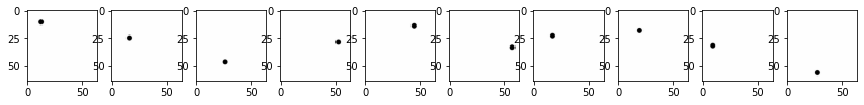

In [5]:
loaded = np.load('data/episodes_0.npz')

w=20#args.screen_size
h=20#args.screen_size
fig=plt.figure(figsize=(30, 10))
cols = 10

smaller_arr = loaded['strokes'][:cols]

for col in range(cols):
    img = smaller_arr[col][:, :, :3]
    #print(img.shape)
    fig.add_subplot(1, 20, col+1)
    plt.grid(False)
    plt.imshow(img)
plt.show()

# VAE Neural Painter

In [6]:
class ConvVAE(object):
  def __init__(self, z_size=64, batch_size=100, learning_rate=0.0001, kl_tolerance=0.5, is_training=True, reuse=False, gpu_mode=True, graph=None):
    self.z_size = z_size
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.is_training = is_training
    self.kl_tolerance = kl_tolerance
    self.reuse = reuse
    # Is it okay to comment this out? with tf.variable_scope('conv_vae', reuse=self.reuse):
    if not gpu_mode:
      with tf.device('/cpu:0'):
        tf.compat.v1.logging.info('conv_vae using cpu.')
        self._build_graph(graph)
    else:
      tf.compat.v1.logging.info('conv_vae using gpu.')
      self._build_graph(graph)
    self._init_session()

  def build_decoder(self, z, reuse=False):
    with tf.compat.v1.variable_scope('decoder', reuse=reuse):
      h = tf.compat.v1.layers.dense(z, 4*256, name="fc")
      h = tf.reshape(h, [-1, 1, 1, 4*256])
      h = tf.compat.v1.layers.conv2d_transpose(h, 128, 5, strides=2, activation=tf.nn.relu, name="deconv1")
      h = tf.compat.v1.layers.conv2d_transpose(h, 64, 5, strides=2, activation=tf.nn.relu, name="deconv2")
      h = tf.compat.v1.layers.conv2d_transpose(h, 32, 6, strides=2, activation=tf.nn.relu, name="deconv3")
      return tf.compat.v1.layers.conv2d_transpose(h, 3, 6, strides=2, activation=tf.nn.sigmoid, name="deconv4")

  def build_predictor(self, actions, reuse=False, is_training=False):
    with tf.compat.v1.variable_scope('predictor', reuse=reuse):
      h = tf.compat.v1.layers.dense(actions, 256, activation=tf.nn.leaky_relu, name="fc1")
      h = tf.compat.v1.layers.batch_normalization(h, training=is_training, name="bn1")
      h = tf.compat.v1.layers.dense(h, 64, activation=tf.nn.leaky_relu, name="fc2")
      h = tf.compat.v1.layers.batch_normalization(h, training=is_training, name="bn2")
      h = tf.compat.v1.layers.dense(h, 64, activation=tf.nn.leaky_relu, name="fc3")
      h = tf.compat.v1.layers.batch_normalization(h, training=is_training, name="bn3")
      return tf.compat.v1.layers.dense(h, self.z_size, name='fc4')

  def _build_graph(self, graph):
    if graph is None:
      self.g = tf.Graph()
    else:
      self.g = graph
    with self.g.as_default(), tf.compat.v1.variable_scope('conv_vae', reuse=self.reuse):

      #### autoencoding part
      self.x = tf.compat.v1.placeholder(tf.float32, shape=[None, 64, 64, 3])

      # Encoder
      h = tf.compat.v1.layers.conv2d(self.x, 32, 4, strides=2, activation=tf.nn.relu, name="enc_conv1")
      h = tf.compat.v1.layers.conv2d(h, 64, 4, strides=2, activation=tf.nn.relu, name="enc_conv2")
      h = tf.compat.v1.layers.conv2d(h, 128, 4, strides=2, activation=tf.nn.relu, name="enc_conv3")
      h = tf.compat.v1.layers.conv2d(h, 256, 4, strides=2, activation=tf.nn.relu, name="enc_conv4")
      h = tf.reshape(h, [-1, 2*2*256])

      # VAE
      self.mu = tf.compat.v1.layers.dense(h, self.z_size, name="enc_fc_mu")
      self.logvar = tf.compat.v1.layers.dense(h, self.z_size, name="enc_fc_log_var")
      self.sigma = tf.exp(self.logvar / 2.0)
      #self.epsilon = tf.random_normal([self.batch_size, self.z_size])
      self.epsilon = tf.random.normal([tf.shape(input=self.sigma)[0], self.z_size])
      self.z = self.mu + self.sigma * self.epsilon

      # Decoder
      self.y = self.build_decoder(self.z)

      #### predicting part
      self.actions = tf.compat.v1.placeholder(tf.float32, shape=[None, 12])
      self.predicted_z = self.build_predictor(self.actions, is_training=self.is_training)
      self.predicted_y = self.build_decoder(self.predicted_z, reuse=True)

      # train ops
      if self.is_training:
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.uneven_multiplier = tf.compat.v1.placeholder_with_default(1.0, [])
        summ_uneven_mult = tf.compat.v1.summary.scalar('uneven_multiplier', self.uneven_multiplier)

        eps = 1e-6 # avoid taking log of zero

        mask = tf.reduce_mean(
          input_tensor=self.x,
          axis = [3]
        )
        stroke_whitespace = tf.equal(mask, 1.0)
        mask = tf.compat.v1.where(stroke_whitespace, tf.ones(tf.shape(input=mask)), self.uneven_multiplier*tf.ones(tf.shape(input=mask)))
        mask = tf.reshape(mask, [-1, 64, 64, 1])
        mask = tf.tile(mask, [1, 1, 1, 3])
        summ_mask = tf.compat.v1.summary.image('mask', mask, max_outputs=3)
        print(mask.get_shape())

        # reconstruction loss
        self.r_loss = tf.reduce_sum(
          input_tensor=(tf.square(self.x - self.y))*mask,
          axis = [1,2,3]
        )
        self.r_loss = tf.reduce_mean(input_tensor=self.r_loss)

        # augmented kl loss per dim
        self.kl_loss = - 0.5 * tf.reduce_sum(
          input_tensor=(1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar)),
          axis = 1
        )
        self.kl_loss = tf.maximum(self.kl_loss, self.kl_tolerance * self.z_size)
        self.kl_loss = tf.reduce_mean(input_tensor=self.kl_loss)

        summ_recon_loss = tf.compat.v1.summary.scalar('recon_loss', self.r_loss)
        summ_kl_loss = tf.compat.v1.summary.scalar('kl_loss', self.kl_loss)
        self.loss = self.r_loss + self.kl_loss

        # training the vae
        self.lr = tf.Variable(self.learning_rate, trainable=False)
        summ_lr = tf.compat.v1.summary.scalar('lr', self.lr)
        self.optimizer = tf.compat.v1.train.AdamOptimizer(self.lr)
        grads = self.optimizer.compute_gradients(
            self.loss,
            tf.compat.v1.global_variables('conv_vae/enc_*')+tf.compat.v1.global_variables('conv_vae/decoder*')) # can potentially clip gradients here.

        self.train_op = self.optimizer.apply_gradients(
          grads, global_step=self.global_step, name='train_step')
        summ_loss = tf.compat.v1.summary.scalar('loss', self.loss)

        # training the predictor
        self.predictor_loss = tf.reduce_mean(input_tensor=tf.square(self.predicted_z - self.z))
        self.optimizer2 = tf.compat.v1.train.AdamOptimizer(self.lr)
        grads2 = self.optimizer2.compute_gradients(self.predictor_loss, tf.compat.v1.global_variables('conv_vae/predictor*'))
        with tf.control_dependencies(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)):
          self.train_op2 = self.optimizer2.apply_gradients(
            grads2, global_step=self.global_step, name='train_step2')
        summ_predictor_loss = tf.compat.v1.summary.scalar('predictor_loss', self.predictor_loss)

        #summary ops
        summ_inp_img = tf.compat.v1.summary.image('inp_img', self.x, max_outputs=3)
        summ_output_img = tf.compat.v1.summary.image('output_img', self.y, max_outputs=3)
        summ_predicted_output_img = tf.compat.v1.summary.image('predicted_output_img', self.predicted_y, max_outputs=3)
        self.summary_op = tf.compat.v1.summary.merge([
            summ_inp_img, summ_output_img, summ_loss, summ_kl_loss, summ_recon_loss,
            summ_mask, summ_uneven_mult, summ_lr
        ])
        self.summary_op_2 = tf.compat.v1.summary.merge([
            summ_inp_img, summ_predictor_loss, summ_output_img, summ_predicted_output_img, summ_lr
        ])


      # initialize vars
      self.init = tf.compat.v1.global_variables_initializer()

  def generate_stroke_graph(self, actions):
    with tf.compat.v1.variable_scope('conv_vae', reuse=True):
      with self.g.as_default():
        # Encoder?
        z = self.build_predictor(actions, reuse=True, is_training=False)

        # Decoder
        return self.build_decoder(z, reuse=True)

  def _init_session(self):
    """Launch TensorFlow session and initialize variables"""
    self.sess = tf.compat.v1.Session(graph=self.g)
    self.sess.run(self.init)
  def close_sess(self):
    """ Close TensorFlow session """
    self.sess.close()
  def save_model(self, model_save_path='tf_vae'):
    sess = self.sess
    step = sess.run(self.global_step)
    with self.g.as_default():
      saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables())
    checkpoint_path = os.path.join(model_save_path, 'vae')
    tf.compat.v1.logging.info('saving model %s.', checkpoint_path)
    saver.save(sess, checkpoint_path, step) # just keep one
  def load_checkpoint(self, checkpoint_path='tf_vae', actual_path=None):
    sess = self.sess
    with self.g.as_default():
      saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables())
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    if actual_path is None:
      actual_path = ckpt.model_checkpoint_path
    print('loading model', actual_path)
    tf.compat.v1.logging.info('Loading model %s.', actual_path)
    saver.restore(sess, actual_path)
  def load_only_vae_checkpoint(self, checkpoint_path='tf_vae', actual_path=None):
    sess = self.sess
    with self.g.as_default():
      to_save = tf.compat.v1.global_variables('conv_vae/enc_*')+tf.compat.v1.global_variables('conv_vae/decoder*')+tf.compat.v1.global_variables('conv_vae/conv_vae/enc_*')+tf.compat.v1.global_variables('conv_vae/conv_vae/decoder*')+tf.compat.v1.global_variables('conv_vae/global_step')
      print(to_save)
      saver = tf.compat.v1.train.Saver(to_save)
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    if actual_path is None:
      actual_path = ckpt.model_checkpoint_path
    print('loading model', actual_path)
    tf.compat.v1.logging.info('Loading model %s.', actual_path)
    saver.restore(sess, actual_path)

# Training the VAE Neural painter

In [14]:
# Hyperparameters for ConvVAE
z_size=64
batch_size=32
learning_rate=0.0001
kl_tolerance=0.5

# Parameters for training
NUM_EPOCH = 5
DATA_DIR = "record"

model_save_path = "tf_vae"
if not os.path.exists(model_save_path):
  os.makedirs(model_save_path)

In [15]:
from tensorflow.python.framework import ops

def reset_graph():
  if 'sess' in globals() and sess:
    sess.close()
  ops.reset_default_graph()

reset_graph()

In [16]:
vae = ConvVAE(z_size=z_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              kl_tolerance=kl_tolerance,
              is_training=True,
              reuse=False,
              gpu_mode=True)


INFO:tensorflow:conv_vae using gpu.
(None, 64, 64, 3)


In [17]:
# Run this to start from a checkpoint
# vae.load_checkpoint('tf_vae')


## Running tensorboard

In [21]:
# #!rm -r logdir

# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format('logdir')
# )

# get_ipython().system_raw('./ngrok http 6006 &')

# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


In [22]:
#!kill $(lsof -t -i:6006)

## Actual training

In [23]:
# TODO: Make file loading more efficient if needed
print("train", "step", "loss", "recon_loss", "kl_loss")
episode_files = tf.io.gfile.glob('data/episodes_*.npz')


# train_writer = tf..summary.create_file_writer('logdir', vae.sess.graph)
for epoch in range(NUM_EPOCH):
  np.random.shuffle(episode_files)

  ep_files = episode_files

  for ep_file in ep_files:
    print(ep_file)
    loaded = np.load(ep_file)
    actions = loaded['actions']
    images = loaded['strokes']
    images = np.reshape(images, [-1, 64, 64, 3])
    #images = images[:, :, :, :3]
    print(images.shape)
    num_batches = int(np.floor(len(images)/batch_size))
    print("num_batches", num_batches)

    for idx in range(num_batches):
      train_step = vae.sess.run(vae.global_step)

      # When training the VAE at the beginning, we add more weight on matching the non-white areas of the brushstroke
      # for the reconstructin loss. Otherwise, it will never learn.
      if train_step > 10000:
        uneven_multiplier = 1.0
      else:
        uneven_multiplier = 10.0

      batch = images[idx*batch_size:(idx+1)*batch_size]

      obs = batch.astype(np.float)/255.0

      feed = {vae.x: obs,
              vae.actions: actions[idx*batch_size:(idx+1)*batch_size],
              vae.uneven_multiplier: uneven_multiplier}

      if train_step < 200000:
        # First part of training trains the VAE
        (train_loss, _, summ) = vae.sess.run([
          vae.loss, vae.train_op, vae.summary_op
        ], feed)
      else:
        # Second part of training trains the predictor

        # Manually adjusted learning rate. Can probably change this to other decay strategies.
        if train_step < 220000:
          feed[vae.lr] = 0.01
        elif train_step < 280000:
          feed[vae.lr] = 0.001
        else:
          feed[vae.lr] = 0.0001
        (train_loss, _, summ) = vae.sess.run([
          vae.predictor_loss, vae.train_op2, vae.summary_op_2
        ], feed)

#       if ((train_step+1) % 50 == 0):
#         train_writer.add_summary(summ, train_step)
      if ((train_step+1) % 500 == 0):
        print("step", (train_step+1), train_loss)
      if ((train_step+1) % 10000 == 0):
        vae.save_model()

train step loss recon_loss kl_loss
data/episodes_4.npz
(1000, 64, 64, 3)
num_batches 31


ValueError: Cannot feed value of shape (32, 2) for Tensor 'conv_vae/Placeholder_1:0', which has shape '(None, 12)'

# Test your trained model

In [ ]:
loaded = np.load('data/episodes_0.npz')
images = loaded['strokes']
images = np.reshape(images[-100:], [-1, 64, 64, 3])
actions = loaded['actions'][-100:]

In [ ]:
test_vae = ConvVAE(z_size=z_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              kl_tolerance=kl_tolerance,
              is_training=False,
              reuse=False,
              gpu_mode=False)

INFO:tensorflow:conv_vae using cpu.


In [ ]:
def plot_images(images):
  h=args.screen_size
  fig=plt.figure(figsize=(16, 16))
  columns = len(images)
  rows = 1

  for i, img in enumerate(images):
    img = img[:, :, :3]
    #print(img.shape)
    fig.add_subplot(rows, columns, i+1)
    plt.grid(False)
    plt.imshow(img)
  plt.show()


('loading model', u'tf_vae/vae-270000')
INFO:tensorflow:Loading model tf_vae/vae-270000.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tf_vae/vae-270000


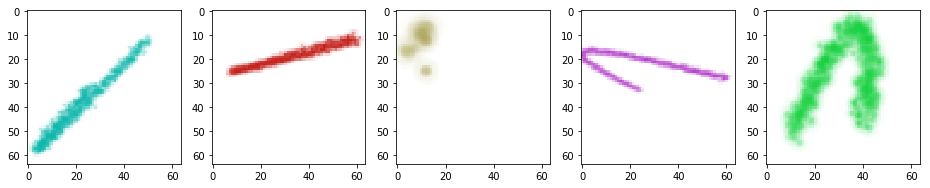

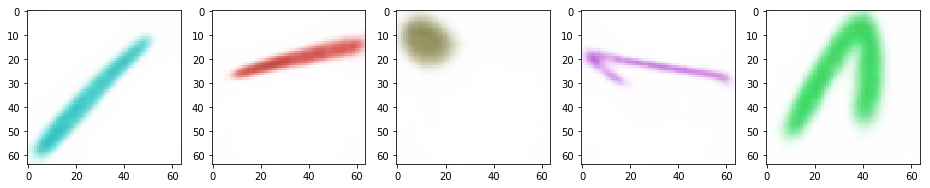

In [ ]:

def experiment(to_plot, fn, actual=None):
  test_vae.load_checkpoint(fn, actual)
  images_to_plot = images[to_plot:to_plot+5].astype(np.float32)/255.
  plot_images(images_to_plot)
  decoded = test_vae.sess.run(test_vae.predicted_y, feed_dict={test_vae.actions: actions[to_plot:to_plot+5]})
  plot_images(decoded)

  plt.show()

experiment(20, 'tf_vae')


In [ ]:

def experiment5(test_models, duration=10.0):
  env = ColorEnv(args, paint_mode=PaintMode.STROKES_ONLY)
  env.reset()

  NUM_ACS = 8
  acs = [env.random_action() for _ in range(NUM_ACS)]

  def frame(t):
    t_ = t / duration
    t = np.abs((1.0-np.cos(NUM_ACS*np.pi*np.mod(t_, 1./NUM_ACS)))/2.0)

    new_ac = (1-t)*acs[int(np.floor(t_*NUM_ACS))] + t*acs[int((np.floor(t_*NUM_ACS)+1)%NUM_ACS)]
    env.draw(new_ac)
    im = env.image
    im = im[:, :, :3]
    stack_these = []
    for test_gan in test_models:
      decoded = test_gan.sess.run(test_gan.predicted_y, feed_dict={test_gan.actions: [new_ac]})[0]
      decoded = (decoded*255).astype(np.uint8)
      concatted = np.concatenate([im, decoded], 1)
      stack_these.append(concatted)
    return np.concatenate(stack_these, axis=0)

  clip = mpy.VideoClip(frame, duration=duration)
  clip.write_videofile('tmp.mp4', fps=30.0)
  display(mpy.ipython_display('tmp.mp4', height=400))



_test_gans = [test_vae]
_test_gans[0].load_checkpoint('tf_vae')
experiment5(_test_gans, 20.)


('loading model', u'tf_vae/vae-270000')
INFO:tensorflow:Loading model tf_vae/vae-270000.
INFO:tensorflow:Restoring parameters from tf_vae/vae-270000
[MoviePy] >>>> Building video tmp.mp4
[MoviePy] Writing video tmp.mp4


100%|█████████▉| 600/601 [00:09<00:00, 63.68it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: tmp.mp4 

